In [1]:
import pypsa 
import atlite 
import vresutils.shapes as vshapes
from vresutils.graph import voronoi_partition_pts
import geopandas as gpd
#import powerplantmatching as pm
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import geopandas as gpd

from pypsa.opt import Constraint as Con

import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr

In [2]:
!hostname

resi


# Build Model

In [7]:
n = pypsa.Network('original-model_original-data')

#tranfer loads, fill NaNs in DongAnh with load values that are nearby its first entry
n.loads_t.p_set['DongAnh'] = n.loads_t.p_set['NghiSon']
#rescale loads (in MW) to approx value of
#https://www.worlddata.info/asia/vietnam/energy-consumption.php (in billion kWh)
n.loads_t.p_set = n.loads_t.p_set / n.loads_t.p_set.sum().sum() * (134.3 * 1e9) / 1e3
loads = n.loads_t.p_set.fillna(0).copy()
n.set_snapshots(pd.DatetimeIndex(start='2015', end='2017', closed='left', freq='h'))
n.loads_t.p_set = (pd.concat([loads.rename(index = lambda ds : ds - pd.Timedelta(270 - i * 52,'W'))
                                 for i in [0,1,2]])
                              [lambda df : ~df.index.duplicated()].reindex(n.snapshots))

n.lines['type'] = '490-AL1/64-ST1A 380.0'
#n.lines['s_nom_min'] = (np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
#                        n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)


storages = pd.read_csv('storage_units.csv', index_col=0)


#drop generators
n.mremove('Generator', n.generators.index)
n.buses['substation_lv'] = True # assume all buses are substations

#add generators from pm 
pm.config.set_target_countries('Vietnam')
ppl = (pm.data.WRI(filter_other_dbs=False) #could also match with pm.data.CARMA()
        .replace({'Fueltype': {'Natural Gas': 'Ocgt'}}))
ppl.loc[ppl.Fueltype=='Hydro', 'Set'] = 'Store'

pm.export.to_pypsa_network(ppl, n)
n.generators = n.generators.assign(p_nom_min = n.generators.p_nom).assign(p_nom_extendable = True)

n.storage_units = (n.storage_units.assign(max_hours = 
                                         storages.max_hours.reindex(n.storage_units.index).fillna(0))
                                 .assign(p_nom_min = n.storage_units.p_nom)
                                 .assign(p_nom_extendable = True))

#add artificial generators for vres 
carriers = ['wind', 'solar', 'bioenergy', 'hard coal', 'oil', 'ocgt', 'nuclear', 'perpetuum']
for carrier in carriers:
    not_included = ((n.buses.index).difference(
                        n.generators[n.generators.carrier == carrier].set_index('bus').index) )
    n.madd('Generator', names = not_included + ' ' + carrier,
                        bus = not_included, carrier=carrier, 
                        p_nom_extendable = True) 

not_included = ((n.buses.index).difference(
                    n.storage_units[n.storage_units.carrier == 'hydro'].set_index('bus').index) )
n.madd('StorageUnit', names = not_included + ' ' + 'hydro',
                    bus = not_included, carrier='hydro',
                    p_nom_extendable = True) 


vietshape = vshapes.countries(subset=['VN'])['VN']
onshore_locs = n.buses.loc[:, ["x", "y"]]
regions = gpd.GeoDataFrame({
        'geometry': voronoi_partition_pts(onshore_locs.values, vietshape),
        'country': 'VN'}, index=onshore_locs.index).rename_axis('bus')
regions.crs = {'init': u'epsg:4326'}
regions['Area'] = regions.geometry.to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)


#%% add cutout
cutout = atlite.Cutout("vietnam-2015-2016-era5", 
                       module='era5', 
                       bounds=[100,6, 112,25],
                       years=slice(2015,2016, None))

cells = gpd.GeoDataFrame({'geometry' : cutout.grid_cells()})
cells.crs = {'init': u'epsg:4326'}
cells['Area'] = cells.geometry.to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)

meta = ( cutout.meta.drop(['height', 'time', 'year-month', 'lat', 'lon'])
                 .to_dataframe().reset_index() )

indicatormatrix = cutout.indicatormatrix(regions.geometry)

#%% add layouts

def custum_layout(meta, cap_per_sq_km):
    return meta.assign(caps = cells.Area * cap_per_sq_km).set_index(['x','y']) \
                .fillna(0).to_xarray().transpose().caps

#hydro
kdtree = KDTree(meta[['x','y']].values)
hydro = ppl[ppl.Fueltype.isin(['hydro'])] 
hydro_grouped = (hydro.assign(
                cell = meta.index[kdtree.query(hydro[['lon','lat']].values)[1]])
                             .groupby(['Fueltype','cell']).Capacity.sum() )

#fill p_nom_max density for unbuilt capacities
#alternative could be 25% quantile of cell density 
hydro_missing_cap = ((n.storage_units.groupby(['carrier', 'bus']).p_nom.sum()['hydro'] / regions.Area)
                        [lambda ds:ds != 0].min())

#expand upper bound for existing capacities by max 50% 
hydro_layout = (pd.concat([meta, hydro_grouped.unstack(0)], axis=1)
          .set_index(['x','y']).mul(1.5) 
          .fillna(hydro_missing_cap).to_xarray().transpose())

#%% calaculate profile via atlite

method = {'wind':'wind', 
          'solar':'pv', 
          'hydro':'runoff'}

resource = {'wind' : {'turbine': 'Vestas_V112_3MW',
                         'layout': custum_layout(meta, 10),
                         'per_unit':True, 'smooth':True
                         }, 
            'solar' : {'panel': 'CSi', 'orientation': 'latitude_optimal',
                       'layout' : custum_layout(meta, 170), 
                       'per_unit':True},
            'hydro' : {'layout': custum_layout(meta, hydro_missing_cap), 
                     'per_unit':False,
                     'smooth':True} }


for carrier in method.keys():
    print(carrier)

    func = getattr(cutout, method[carrier])
    profile, capacities = func(matrix=indicatormatrix, index=regions.index,
                           return_capacity=True, **resource[carrier])
        
    profile = (profile.to_pandas().T.rename(columns=lambda x: x + ' ' + carrier))
    capacities = capacities.to_series().rename(index = lambda ds: ds + ' ' + carrier) 

    if carrier=='hydro':
#        assume hydro generation statistics 
#        from https://www.hydropower.org/country-profiles/vietnam
        
        capacities = n.storage_units.p_nom_min.where( n.storage_units.p_nom_min > 0, capacities)
        inflow = profile * capacities
        #assume about 10% will be spillage
        inflow *= (120.0*1e6)/inflow.sum().reindex((n.storage_units.p_nom_min>0).index).sum() 
        n.storage_units_t.inflow = inflow
        n.storage_units.p_nom_max = capacities * 1.1  

    else:       
        n.generators.loc[capacities.index, 'p_nom_max'] = capacities
        n.generators_t.p_max_pu =  pd.concat( [n.generators_t.p_max_pu , profile], axis=1)


#only assumptions, no research done on this yet
costs = pd.read_csv('costs.csv', index_col=0)
n.generators['marginal_cost'] = n.generators.carrier.map(costs.marginal)
n.generators['capital_cost'] = n.generators.carrier.map(costs.capital)
n.generators['weight'] = 1.0
n.storage_units['marginal_cost'] = n.storage_units.carrier.map(costs.marginal)
n.storage_units['capital_cost'] = n.storage_units.carrier.map(costs.capital)
n.lines.capital_cost =  0.4*n.lines.length #Davids assumption


#only assumptions, no research done on this yet
n.carriers = n.carriers.rename(index= lambda ds: ds.lower()).rename(index= {'windon': 'wind'})
co_2 = dict(zip(carriers, [0.0, 0.0, 0.0, 427.7, 405.0, 230.0, 0.0, 0.0]))
short = dict(zip(carriers, ['W', 'S', 'B', 'C', 'O', 'G', 'N', 'P']))
for carrier in carriers:
    n.carriers.loc[carrier, 'co2_emissions'] = co_2[carrier]
    n.carriers.loc[carrier, 'short_name'] = short[carrier]
n.carriers.loc['hydro', 'co2_emissions'] = 0.0
n.carriers.loc['hydro', 'short_name'] = 'H'

# Fix small values
n.generators_t.p_max_pu[n.generators_t.p_max_pu <= 1e-6] = 0.0

n.export_to_netcdf('vietnam3.nc')

Importing PyPSA from older version of PyPSA than current version 0.13.1.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network original-model_original-data has buses, carriers, generators, lines, loads


AttributeError: module 'powerplantmatching.config' has no attribute 'set_target_countries'

# Remove Lines

In [ ]:
n = pypsa.Network('vietnam3.nc')

# Where are the buses located?
#fig, ax = plt.subplots(1,1, figsize=(15,15))
#n.plot(ax=ax)
#for bus in n.buses.index:
#    plt.annotate(s=bus, xy=(n.buses.loc[bus].x,n.buses.loc[bus].y))

# Cut north and south:
# Remove DaNang -> HaTinh    label 28
# Remove DaNang -> VungAng   label 29
#pd.set_option('display.max_rows', 1000)

n.lines = n.lines.drop(labels=['28', '29'])

n.export_to_netcdf('vietnam3_disconnected.nc')

# Adjust Range

In [9]:
# Fix small values
n = pypsa.Network('vietnam3.nc')
n.generators_t.p_max_pu[n.generators_t.p_max_pu <= 1e-6] = 0.0
n.export_to_netcdf('vietnam3_fixed.nc')

n = pypsa.Network('vietnam3_disconnected.nc')
n.generators_t.p_max_pu[n.generators_t.p_max_pu <= 1e-6] = 0.0
n.export_to_netcdf('vietnam3_disconnected_fixed.nc')

INFO:pypsa.io:Imported network vietnam3.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Exported network vietnam3_fixed.nc has lines, carriers, storage_units, generators, loads, buses
INFO:pypsa.io:Imported network vietnam3_disconnected.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Exported network vietnam3_disconnected_fixed.nc has lines, carriers, storage_units, generators, loads, buses


<xarray.Dataset>
Dimensions:                         (buses_i: 46, carriers_i: 9, generators_i: 368, generators_t_p_max_pu_i: 92, lines_i: 63, loads_i: 46, loads_t_p_set_i: 46, snapshots: 17544, storage_units_i: 46, storage_units_t_inflow_i: 46)
Coordinates:
  * snapshots                       (snapshots) datetime64[ns] 2015-01-01 ...
  * lines_i                         (lines_i) object '1' '2' '3' '4' '5' '6' ...
  * carriers_i                      (carriers_i) object 'wind' 'solar' ...
  * storage_units_i                 (storage_units_i) object 'ChonThanh hydro' ...
  * storage_units_t_inflow_i        (storage_units_t_inflow_i) object 'CauBong hydro' ...
  * generators_i                    (generators_i) object 'CongThanh hard coal' ...
  * generators_t_p_max_pu_i         (generators_t_p_max_pu_i) object 'HiepHoa wind' ...
  * loads_i                         (loads_i) object 'HiepHoa' 'LaiChauH' ...
  * loads_t_p_set_i                 (loads_t_p_set_i) object 'HiepHoa' ...
  * buses

# Build Scenario

In [3]:
def scenario_constraints(n,snapshots,limits=None,flexibility=0.1):
    carrier_constraints = ['wind', 'solar', 'hydro', 'bioenergy',
                           'hard coal', 'oil', 'ocgt', 'nuclear']
    
    for constraint in limits.index:
        if constraint in carrier_constraints:
            if constraint == 'hydro':
                index = n.storage_units[n.storage_units['carrier']==constraint].index
                setattr(n.model,constraint+"_limit_low",Con(expr=sum(n.model.storage_p_nom[name] \
                                                          for name in index) >= limits[constraint] * (1.-flexibility)))
                setattr(n.model,constraint+"_limit_up",Con(expr=sum(n.model.storage_p_nom[name] \
                                                          for name in index) <= limits[constraint] * (1.+flexibility)))
            else:
                index = n.generators[n.generators['carrier']==constraint].index
                setattr(n.model,constraint+"_limit_low",Con(expr=sum(n.model.generator_p_nom[name] \
                                                          for name in index) >= limits[constraint] * (1.-flexibility)))
                setattr(n.model,constraint+"_limit_up",Con(expr=sum(n.model.generator_p_nom[name] \
                                                          for name in index) <= limits[constraint] * (1.+flexibility)))
    return



def set_constraints(network, snapshots):
    return scenario_constraints(network, snapshots, limits = limits, flexibility = flexibility)

In [4]:
def renewable_scenario_constraints(n,snapshots,limits=None,flexibility=0.1):
    carrier_constraints = ['hydro', 'nuclear']
    
    for constraint in limits.index:
        if constraint in carrier_constraints:
            if constraint == 'hydro':
                index = n.storage_units[n.storage_units['carrier']==constraint].index
                setattr(n.model,constraint+"_limit_low",Con(expr=sum(n.model.storage_p_nom[name] \
                                                          for name in index) >= limits[constraint] * (1.-flexibility)))
                setattr(n.model,constraint+"_limit_up",Con(expr=sum(n.model.storage_p_nom[name] \
                                                          for name in index) <= limits[constraint] * (1.+flexibility)))
            else:
                index = n.generators[n.generators['carrier']==constraint].index
                setattr(n.model,constraint+"_limit_low",Con(expr=sum(n.model.generator_p_nom[name] \
                                                          for name in index) >= limits[constraint] * (1.-flexibility)))
                setattr(n.model,constraint+"_limit_up",Con(expr=sum(n.model.generator_p_nom[name] \
                                                          for name in index) <= limits[constraint] * (1.+flexibility)))
    return



def renewable_set_constraints(network, snapshots):
    return renewable_scenario_constraints(network, snapshots, limits = limits, flexibility = flexibility)

# LOPF

In [ ]:
n = pypsa.Network('vietnam3.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2020]
flexibility = 0.1

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs'

name = 'vietnam'
scenario = 'devplan_2020'

n.lopf(extra_functionality = set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2025]
flexibility = 0.1

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs'

name = 'vietnam'
scenario = 'devplan_2025'

n.lopf(extra_functionality = set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2030]
flexibility = 0.1

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs'

name = 'vietnam'
scenario = 'devplan_2030'

n.lopf(extra_functionality = set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_disconnected.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2020]
flexibility = 0.1

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs-disconnected'

name = 'vietnam'
scenario = 'devplan_2020'

n.lopf(extra_functionality = set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_disconnected.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2025]
flexibility = 0.1

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs-disconnected'

name = 'vietnam'
scenario = 'devplan_2025'

n.lopf(extra_functionality = set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_disconnected.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2030]
flexibility = 0.1

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs-disconnected'

name = 'vietnam'
scenario = 'devplan_2030'

n.lopf(extra_functionality = set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_fixed.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2020]
flexibility = 0.1
co2_limit = 1.84*87.84e6*0.05 #tons_per_citizen*citizens http://www.worldbank.org/ 2011 data

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

n.global_constraints = n.global_constraints.reindex(['co2_limit'])
n.global_constraints.type = 'primary_energy'
n.global_constraints.carrier_attribute = 'co2_emissions'
n.global_constraints.sense = '<='
n.global_constraints.constant = co2_limit #tons
n.global_constraints.mu = 0.0

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs'

name = 'vietnam'
scenario = 'renewable_2020'

n.lopf(extra_functionality = renewable_set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_fixed.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2025]
flexibility = 0.1
co2_limit = 1.84*87.84e6*0.05 #tons_per_citizen*citizens http://www.worldbank.org/ 2011 data

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

n.global_constraints = n.global_constraints.reindex(['co2_limit'])
n.global_constraints.type = 'primary_energy'
n.global_constraints.carrier_attribute = 'co2_emissions'
n.global_constraints.sense = '<='
n.global_constraints.constant = co2_limit #tons
n.global_constraints.mu = 0.0

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs'

name = 'vietnam'
scenario = 'renewable_2025'

n.lopf(extra_functionality = renewable_set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_fixed.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2030]
flexibility = 0.1
co2_limit = 1.84*87.84e6*0.05 #tons_per_citizen*citizens http://www.worldbank.org/ 2011 data

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

n.global_constraints = n.global_constraints.reindex(['co2_limit'])
n.global_constraints.type = 'primary_energy'
n.global_constraints.carrier_attribute = 'co2_emissions'
n.global_constraints.sense = '<='
n.global_constraints.constant = co2_limit #tons
n.global_constraints.mu = 0.0

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs'

name = 'vietnam'
scenario = 'renewable_2030'

n.lopf(extra_functionality = renewable_set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_disconnected_fixed.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2020]
flexibility = 0.1
co2_limit = 1.84*87.84e6*0.05 #tons_per_citizen*citizens http://www.worldbank.org/ 2011 data

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

n.global_constraints = n.global_constraints.reindex(['co2_limit'])
n.global_constraints.type = 'primary_energy'
n.global_constraints.carrier_attribute = 'co2_emissions'
n.global_constraints.sense = '<='
n.global_constraints.constant = co2_limit #tons
n.global_constraints.mu = 0.0

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs-disconnected'

name = 'vietnam'
scenario = 'renewable_2020'

n.lopf(extra_functionality = renewable_set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_disconnected_fixed.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2025]
flexibility = 0.1
co2_limit = 1.84*87.84e6*0.05 #tons_per_citizen*citizens http://www.worldbank.org/ 2011 data

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

n.global_constraints = n.global_constraints.reindex(['co2_limit'])
n.global_constraints.type = 'primary_energy'
n.global_constraints.carrier_attribute = 'co2_emissions'
n.global_constraints.sense = '<='
n.global_constraints.constant = co2_limit #tons
n.global_constraints.mu = 0.0

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs-disconnected'

name = 'vietnam'
scenario = 'renewable_2025'

n.lopf(extra_functionality = renewable_set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

In [ ]:
n = pypsa.Network('vietnam3_disconnected_fixed.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2030]
flexibility = 0.1
co2_limit = 1.84*87.84e6*0.05 #tons_per_citizen*citizens http://www.worldbank.org/ 2011 data

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

n.global_constraints = n.global_constraints.reindex(['co2_limit'])
n.global_constraints.type = 'primary_energy'
n.global_constraints.carrier_attribute = 'co2_emissions'
n.global_constraints.sense = '<='
n.global_constraints.constant = co2_limit #tons
n.global_constraints.mu = 0.0

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs-disconnected'

name = 'vietnam'
scenario = 'renewable_2030'

n.lopf(extra_functionality = renewable_set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

# Plots

In [3]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/devplan_2030/')

colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink']))

bus_scale = 1e4
link_scale = 1e3

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [4]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(4948.2280858635258, 8496.5543187349758, 14746.290290585001)

In [5]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(5642.808938317, 6867.8636540950001, 8911.0972292200004)

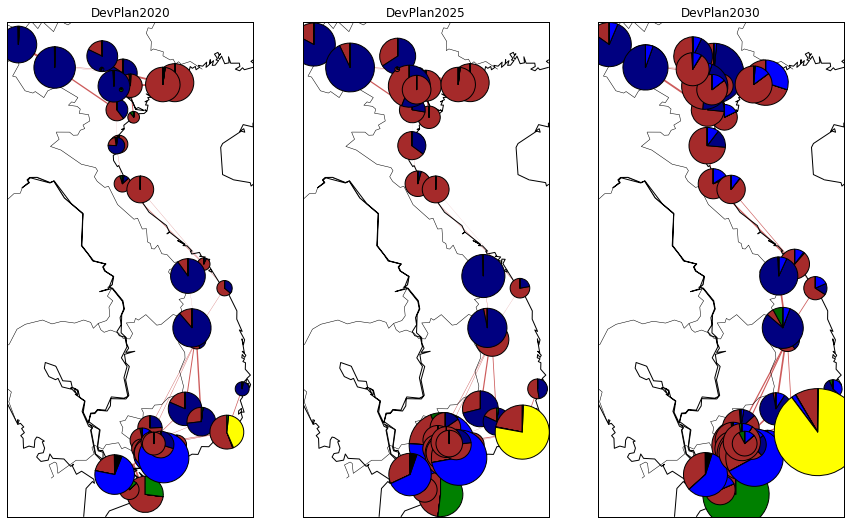

In [7]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='DevPlan2020')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='DevPlan2025')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='DevPlan2030')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/plots/devplan_all.pdf',
            bbox_inches='tight')

In [24]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs-disconnected/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs-disconnected/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs-disconnected/devplan_2030/')

colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink']))

bus_scale = 1e4
link_scale = 1e3

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [25]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(5023.9582167868639, 7986.7800624199581, 14762.636874170999)

In [26]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(5360.3186440190002, 6923.4868071450001, 8074.9402673299992)

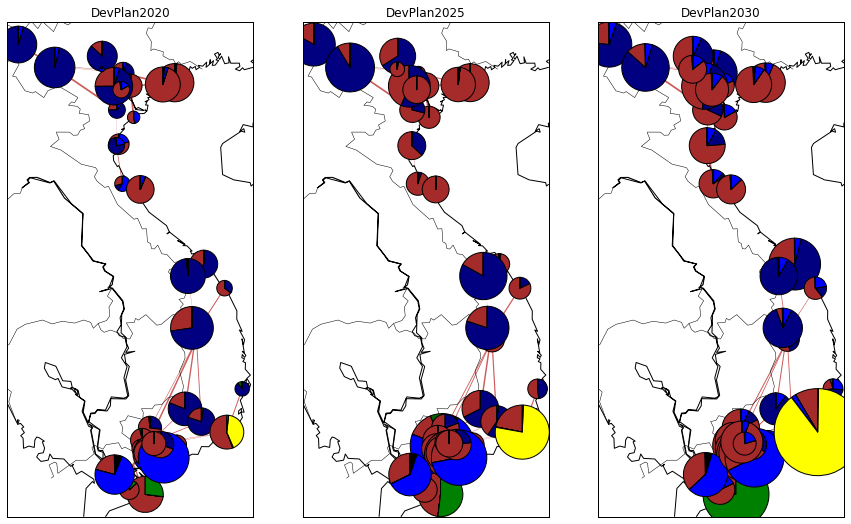

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes = axes.flatten()
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=axes[0],
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='DevPlan2020')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=axes[1],
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='DevPlan2025')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=axes[2],
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='DevPlan2030')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data_final-runs-disconnected/plots/devplan_all.pdf',
            bbox_inches='tight')

In [8]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/renewable_2030/')

colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink']))

bus_scale = 1e5
link_scale = 1e4

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [9]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(104488.62444997954, 196061.13213647893, 249572.452632456)

In [10]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(37570.784944109997, 51454.857043600001, 59672.320322900006)

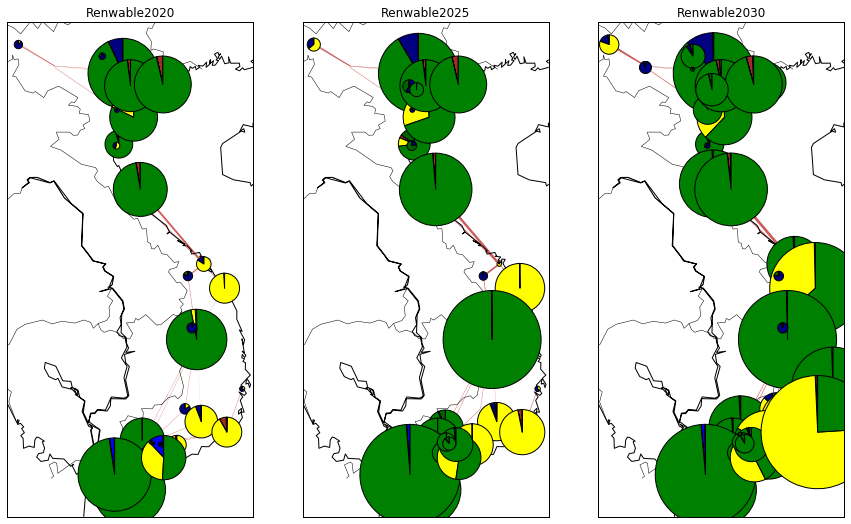

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes = axes.flatten()
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=axes[0],
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='Renwable2020')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=axes[1],
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='Renwable2025')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=axes[2],
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='Renwable2030')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/plots/renewable_all.pdf',
            bbox_inches='tight')

In [12]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs-disconnected/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs-disconnected/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs-disconnected/renewable_2030/')

colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink']))

bus_scale = 1e5
link_scale = 1e4

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [13]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(148872.37894050463, 196319.76304928513, 233097.56538331188)

In [14]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(18406.577794889999, 23756.96909672, 35804.018658429995)

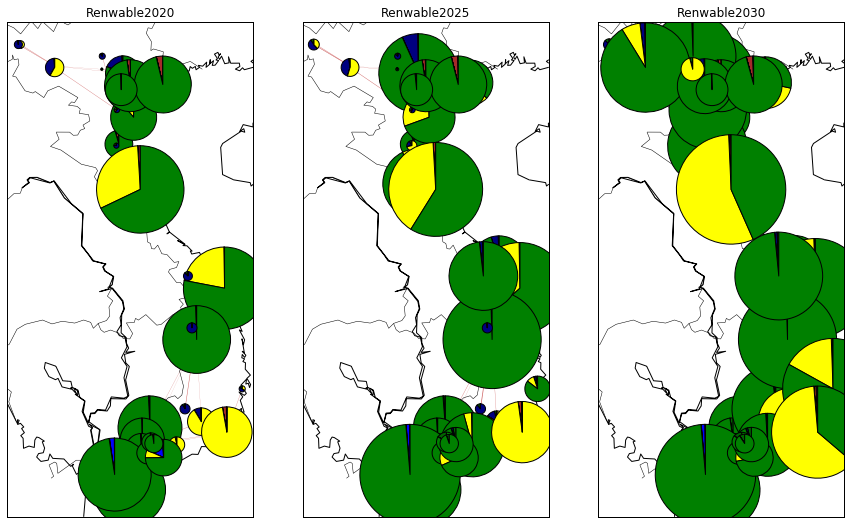

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes = axes.flatten()
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=axes[0],
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='Renwable2020')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=axes[1],
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='Renwable2025')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=axes[2],
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='Renwable2030')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data_final-runs-disconnected/plots/renewable_all.pdf',
            bbox_inches='tight')

# Analyse Data

In [6]:
n = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_final-runs/devplan_2020/')

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [21]:
n.generators.groupby(['bus','carrier']).sum().p_nom_opt

bus        carrier  
CauBong    bioenergy        0.000000
           hard coal     3581.181124
           nuclear        256.015149
           ocgt          4909.804164
           oil           1108.200000
           perpetuum        0.000000
           solar            0.000000
           wind             0.000000
ChonThanh  bioenergy        0.000000
           hard coal     2067.017667
           nuclear        347.429501
           ocgt             0.000000
           oil              0.000000
           perpetuum        0.000000
           solar            0.000000
           wind             0.000000
CongThanh  bioenergy       30.319727
           hard coal     1083.220153
           nuclear        127.360278
           ocgt           344.934237
           oil              0.000000
           perpetuum        0.000000
           solar            0.000000
           wind             0.000000
CuChi      bioenergy        0.000000
           hard coal     1899.274317
           nuclea

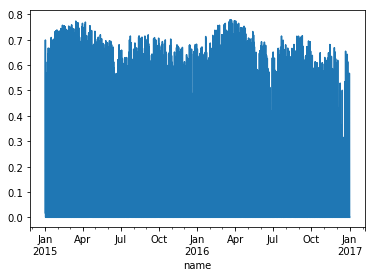

In [28]:
n.generators_t.p_max_pu['VinhTan solar'].plot()

# Debugging

In [16]:
n = pypsa.Network('vietnam3.nc')

INFO:pypsa.io:Imported network vietnam3.nc has buses, carriers, generators, lines, loads, storage_units


In [17]:
# Fix small values
n.generators_t.p_max_pu[n.generators_t.p_max_pu <= 1e-2] = 0.0

n.export_to_netcdf('vietnam3_debugging.nc')

INFO:pypsa.io:Exported network vietnam3_debugging.nc has generators, lines, carriers, buses, storage_units, loads


<xarray.Dataset>
Dimensions:                         (buses_i: 46, carriers_i: 9, generators_i: 368, generators_t_p_max_pu_i: 92, lines_i: 65, loads_i: 46, loads_t_p_set_i: 46, snapshots: 17544, storage_units_i: 46, storage_units_t_inflow_i: 46)
Coordinates:
  * snapshots                       (snapshots) datetime64[ns] 2015-01-01 ...
  * generators_i                    (generators_i) object 'CongThanh hard coal' ...
  * generators_t_p_max_pu_i         (generators_t_p_max_pu_i) object 'HiepHoa wind' ...
  * lines_i                         (lines_i) object '1' '2' '3' '4' '5' '6' ...
  * carriers_i                      (carriers_i) object 'wind' 'solar' ...
  * buses_i                         (buses_i) object 'HiepHoa' 'LaiChauH' ...
  * storage_units_i                 (storage_units_i) object 'ChonThanh hydro' ...
  * storage_units_t_inflow_i        (storage_units_t_inflow_i) object 'CauBong hydro' ...
  * loads_i                         (loads_i) object 'HiepHoa' 'LaiChauH' ...
  * lo

In [ ]:
n = pypsa.Network('vietnam3_debugging.nc')

# Configure scenario settings
scenarios = pd.read_csv('scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)
limits = scenarios.loc[2020]
flexibility = 0.1

n.storage_units.p_nom_max = np.Inf
n.loads_t.p_set = n.loads_t.p_set * limits['load_increase']

model = 'fias-model'
data = 'era5-data'
attribute = 'final-runs-debugging'

name = 'vietnam'
scenario = 'devplan_2020'

n.lopf(extra_functionality = set_constraints,
       snapshots=n.snapshots[:8760], solver_name='gurobi', solver_options={"threads":12, "method":-1, "crossover":-1}, 
       formulation='kirchhoff', keep_files=False)

n.name = name + '_' + scenario
n.export_to_csv_folder('/home/vres/data/ReVietSys/' + model + '_' + data + '_' + attribute + '/' + scenario)

INFO:pypsa.io:Imported network vietnam3_debugging.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.pf:Slack bus for sub-network 0 is CongThanh
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.pf:Tree slack bus is SongMay with degree 4.
INFO:pypsa.pf:Slack bus for sub-network 0 is CongThanh
INFO:pypsa.pf:Slack bus for sub-network 0 is CongThanh
INFO:pypsa.opf:Solving model using gurobi
